# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [2]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
# y = "health level" - predicted variable, dependent variable
# x = "took the drug" - explanatory variable, independent variable
# omitted variable == confounding variable



In [3]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [4]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=88.35781657959527, mobile=True), User(purchased=False, time_on_site=152.6557617933774, mobile=True), User(purchased=False, time_on_site=51.930594659474046, mobile=False), User(purchased=True, time_on_site=540.0276193666349, mobile=False), User(purchased=False, time_on_site=152.50728542376214, mobile=True), User(purchased=False, time_on_site=89.0384053913883, mobile=True), User(purchased=False, time_on_site=410.5411988300685, mobile=False), User(purchased=False, time_on_site=198.939031760044, mobile=True), User(purchased=True, time_on_site=248.65034472570963, mobile=True), User(purchased=False, time_on_site=387.0730623290841, mobile=False)]


In [5]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,88.357817,True
1,False,152.655762,True
2,False,51.930595,False
3,True,540.027619,False
4,False,152.507285,True


In [6]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.364595746778776,5.412613823234842,5.700752445954109,5.862304060072597,6.848316696161172,7.578043639511591,9.225269658507347,10.054092570117259,10.123707547700713,11.039108000417416,...,573.4026416828531,574.3267407577531,575.5968814056612,575.7186638685422,577.222032296774,577.3018279539373,593.2475010836067,594.3762883882501,595.0858385583314,598.4405879536537
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,0,0,1,1,1,1,0,0,...,0,1,0,1,0,0,1,1,1,1
True,0,0,1,1,0,0,0,0,1,1,...,1,0,1,0,1,1,0,0,0,0


In [7]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.772, 123.98]","(123.98, 242.595]","(242.595, 361.21]","(361.21, 479.825]","(479.825, 598.441]"
purchased,,,,,
False,243,225,111,33,33
True,114,119,67,29,26


In [8]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.772, 123.98]","(123.98, 242.595]","(242.595, 361.21]","(361.21, 479.825]","(479.825, 598.441]"
purchased,,,,,
False,0.680672,0.65407,0.623596,0.532258,0.559322
True,0.319328,0.34593,0.376404,0.467742,0.440678


In [9]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.672,0.636
True,0.328,0.364


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

In [0]:
import pandas as pd
exercise_data = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv')

In [16]:
exercise_data.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [17]:
exercise_data.count()

Unnamed: 0       1200
age              1200
weight           1200
exercise_time    1200
dtype: int64

In [18]:
exercise_data.isna().sum()

Unnamed: 0       0
age              0
weight           0
exercise_time    0
dtype: int64

In [20]:
import numpy as np

exercise_data_cleaned = exercise_data.replace('?',np.NaN)
exercise_data_cleaned.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [36]:
exercise_data_cleaned.dtypes

Unnamed: 0       int64
age              int64
weight           int64
exercise_time    int64
dtype: object

In [48]:
age_data = exercise_data_cleaned.age
weight_data = exercise_data_cleaned.weight
exercisetime_data = exercise_data_cleaned.exercise_time
print(age_data)
print(weight_data)
print(exercisetime_data)

0       44
1       41
2       46
3       39
4       28
5       58
6       55
7       21
8       55
9       50
10      21
11      43
12      73
13      27
14      21
15      36
16      49
17      69
18      18
19      55
20      19
21      34
22      20
23      20
24      32
25      71
26      21
27      79
28      72
29      26
        ..
1170    22
1171    56
1172    27
1173    74
1174    30
1175    61
1176    57
1177    38
1178    67
1179    69
1180    34
1181    41
1182    49
1183    70
1184    57
1185    35
1186    61
1187    48
1188    71
1189    35
1190    70
1191    29
1192    51
1193    33
1194    64
1195    47
1196    29
1197    29
1198    25
1199    67
Name: age, Length: 1200, dtype: int64
0       118
1       161
2       128
3       216
4       116
5       103
6       161
7       188
8       216
9       127
10      160
11      102
12      209
13      165
14      169
15      131
16      171
17      172
18      122
19      157
20      218
21      143
22      116
23      159
24 

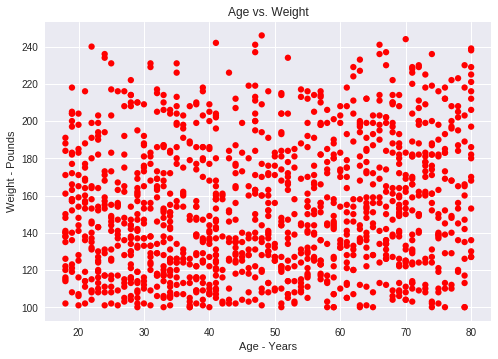

In [83]:
g1 = age_data
g2 = weight_data
g3 = exercisetime_data

plt.xlabel('Age - Years')
plt.ylabel('Weight - Pounds')
plt.title('Age vs. Weight')
plt.scatter(g1, g2, c='red',edgecolor='none', s=40)

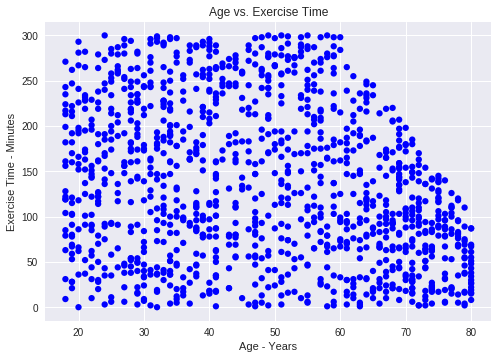

In [85]:
g1 = age_data
g2 = weight_data
g3 = exercisetime_data

plt.xlabel('Age - Years')
plt.ylabel('Exercise Time - Minutes')
plt.title('Age vs. Exercise Time')

plt.scatter(g1, g3, c='blue',edgecolor='none', s=40)

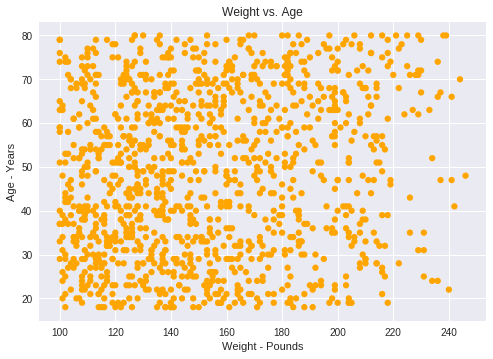

In [87]:
g1 = age_data
g2 = weight_data
g3 = exercisetime_data

plt.xlabel('Weight - Pounds')
plt.ylabel('Age - Years')
plt.title('Weight vs. Age')


plt.scatter(g2, g1, c='orange',edgecolor='none', s=40)

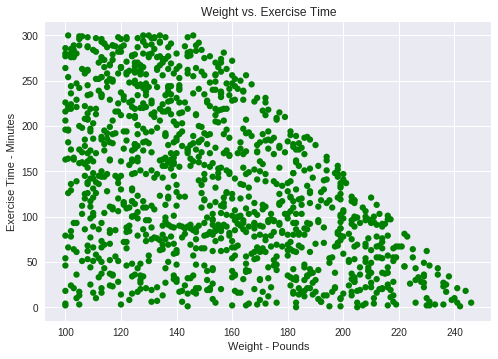

In [88]:
g1 = age_data
g2 = weight_data
g3 = exercisetime_data

plt.xlabel('Weight - Pounds')
plt.ylabel('Exercise Time - Minutes')
plt.title('Weight vs. Exercise Time')

plt.scatter(g2, g3, c='green',edgecolor='none', s=40)

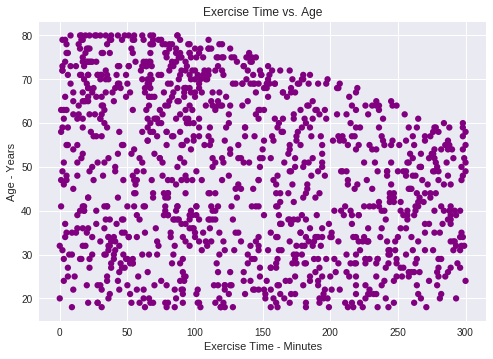

In [89]:
g1 = age_data
g2 = weight_data
g3 = exercisetime_data

plt.xlabel('Exercise Time - Minutes')
plt.ylabel('Age - Years')
plt.title('Exercise Time vs. Age')

plt.scatter(g3, g1, c='purple',edgecolor='none', s=40)

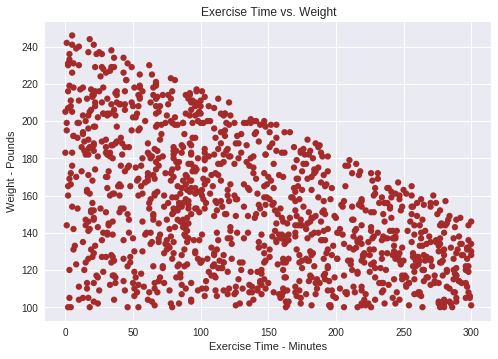

In [91]:
g1 = age_data
g2 = weight_data
g3 = exercisetime_data

plt.xlabel('Exercise Time - Minutes')
plt.ylabel('Weight - Pounds')
plt.title('Exercise Time vs. Weight')

plt.scatter(g3, g2, c='brown',edgecolor='none', s=40)

**What are the variable types in the data?**
I would say that Age, Weight, and Exercise Time are discrete variables.

Age is a finite number in this data set.  We do not have 90-year-old, 100-year-olds or 200-year-old examples.

Weight is a finite number in this data set.  No one weighs more than 250 lbs.

Exercise Time is a finite number in this data set.  No one exercises more than 300 minutes.


**What are the relationships between the variables?**
Weight is a dependent variable to Exercise Time (independent variable).

Exercise Time is a dependent variable to Age (independent variable).

I did not see any examples of confounding variables.


**Which relationships are "real", and which spurious?**

The relationship between Exercise Time & Weight is real. The more you exercise, the less you weigh.

The relationship between Exercise Time & Age is real.  The older you are, the less you exercise.

The relationship between Age & Weight is mostly spurious or unrelated.  You could argue that the younger you are the less one weighs.

The age group that was between 20-years-old and 50-years-old mostly fell in the 100 lbs to 180 lb range.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)